In [1]:
import os
import pickle
import shutil
import pandas as pd
import numpy as np

C:\Users\goert\AppData\Local\Temp\ipykernel_16764\619488019.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_SUBPATH = '/data'
DATASET_PATH = MAIN_PATH + DATA_SUBPATH + '/unzip/WESAD'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'

In [3]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
print(folders)

['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17']


This process unpacking the zip files can take up to 3 minutes. Depending on the computational power available.

In [4]:
shutil.unpack_archive(MAIN_PATH + DATA_SUBPATH + '/WESAD.zip', MAIN_PATH + DATA_SUBPATH + '/unzip')

In [5]:
data_folders = []
for subfolder in folders:
    data_folders.append(f"{MAIN_PATH}{DATA_SUBPATH}/unzip/WESAD/{subfolder}/{subfolder}_E4_Data.zip")
print(data_folders)

['d:\\Master of Applied IT/data/unzip/WESAD/S2/S2_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S3/S3_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S4/S4_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S5/S5_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S6/S6_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S7/S7_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S8/S8_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S9/S9_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S10/S10_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S11/S11_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S12/S12_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S13/S13_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S14/S14_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S15/S15_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WESAD/S16/S16_E4_Data.zip', 'd:\\Master of Applied IT/data/unzip/WES

In [6]:
for folder, data_folder in zip(folders, data_folders):
    try:
        shutil.unpack_archive(data_folder, os.path.join(UNPROCESSED_PATH, f'{folder}'))
        print("Preparing folder:", folder)
    except shutil.ReadError:
        print(f"Skipping {data_folder} as it is not a zip file or missing.")

print("Finished unzipping and preparing files.")

Preparing folder: S2
Preparing folder: S3
Preparing folder: S4
Preparing folder: S5
Preparing folder: S6
Preparing folder: S7
Preparing folder: S8
Preparing folder: S9
Preparing folder: S10
Preparing folder: S11
Skipping d:\Master of Applied IT/data/unzip/WESAD/S12/S12_E4_Data.zip as it is not a zip file or missing.
Preparing folder: S13
Preparing folder: S14
Preparing folder: S15
Preparing folder: S16
Preparing folder: S17
Finished unzipping and preparing files.


In [27]:
import numpy as np
import pandas as pd
import os
from scipy.stats import mode

# Define the source and destination paths
source_folder = DATASET_PATH
destination_folder = UNPROCESSED_PATH

original_rate = 700
target_rate = 4

def create_destination_folder(destination_folder, folder):
    # Create the destination folder if it doesn't exist
    destination_path = os.path.join(destination_folder, folder)
    os.makedirs(destination_path, exist_ok=True)
    return destination_path

# Iterate over the folders
for folder in folders:
    destination_path = create_destination_folder(destination_folder, folder)
        
    # Open the pickle file
    source_path = os.path.join(source_folder, folder, f'{folder}.pkl')
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        continue
        
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        
        print('label of:' + str(data['label']))

         # Resample signals
        w_ax = data['signal']['wrist']['ACC'][:,0]
        w_ay = data['signal']['wrist']['ACC'][:,1]
        w_az = data['signal']['wrist']['ACC'][:,2]
        w_bvp = data['signal']['wrist']['BVP'][:,0]
        w_eda = data['signal']['wrist']['EDA'][:,0]
        w_temp = data['signal']['wrist']['TEMP'][:,0]
        labels = data['label']

        # Calculate decimation factor
        decimation_factor = len(labels) // (original_rate // target_rate)        
        
        # Perform downsampling with mode filtering
        downsampled_data = []
        for i in range(0, len(labels), decimation_factor):
            segment = labels[i:i + decimation_factor]
            mode_value, _ = mode(segment)  # Extract mode value
            downsampled_data.append(mode_value)

        print(len(labels))
        print(len(downsampled_data)) 

        print(f"Equated: {folder}")

        # Ensure all arrays are of equal length
        min_length = min(len(w_eda), len(w_temp), len(downsampled_data))
        w_eda = w_eda[:min_length]
        w_temp = w_temp[:min_length]
        downsampled_data = downsampled_data[:min_length]

        # Create numpy array
        numpy_data1 = np.array([w_eda, w_temp, downsampled_data]).T

        df = pd.DataFrame(data=numpy_data1, columns=["w_eda", "w_temp", "downsampled_labels"]) 
        df['ID'] = folder
        df['Time'] = np.arange(len(w_eda)) / 4
        df['downsampled_labels'] = df['downsampled_labels'].replace([5, 6, 7], 0)
        
        # Save the dataframe as a CSV file
        csv_path = os.path.join(destination_path, f'{folder}.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")


label of:[0 0 0 ... 0 0 0]
4255300
175
Equated: S2
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S2\S2.csv
label of:[0 0 0 ... 0 0 0]
4545100
175
Equated: S3
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S3\S3.csv
label of:[0 0 0 ... 0 0 0]
4496100
175
Equated: S4
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S4\S4.csv
label of:[0 0 0 ... 0 0 0]
4380600
175
Equated: S5
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S5\S5.csv
label of:[0 0 0 ... 0 0 0]
4949700
175
Equated: S6
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S6\S6.csv
label of:[0 0 0 ... 0 0 0]
3666600
175
Equated: S7
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S7\S7.csv
label of:[0 0 0 ... 0 0 0]
3826200
175
Equated: S8
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S8\S8.csv
label of:[0 0 0 ... 0 0 0]
3656100
175
Equated: S9
Saved: d:\Master of Applied IT/data/unprocessed/WESAD\S9\S9.csv
label of:[0 0 0 ... 0 0 0]
3847200
175
Equated: S10
Saved: d:\Master of Applied 

In [28]:
len(labels)

4144000

In [29]:
w_eda

array([2.015176, 2.012617, 2.001103, 2.030529, 1.979353, 1.965279,
       1.960162, 1.972197, 1.968359, 1.96452 , 1.968359, 1.960682,
       1.98627 , 1.995226, 2.001623, 2.00802 , 2.00802 , 2.014417,
       2.118049, 2.034888, 2.024652, 2.019535, 2.02977 , 2.015697,
       2.027211, 2.031049, 2.032329, 2.047682, 2.056638, 2.063035,
       2.068152, 2.07199 , 2.063035, 2.07199 , 2.166666, 2.185857,
       2.176902, 2.169225, 2.165387, 2.160269, 2.164108, 2.15899 ,
       2.165387, 2.18074 , 2.193534, 2.194813, 2.192254, 2.184578,
       2.203769, 2.197372, 2.190975, 2.193534, 2.188416, 2.192254,
       2.183299, 2.189696, 2.188416, 2.187137, 2.188416, 2.185857,
       2.185857, 2.182019, 2.188416, 2.178181, 2.182019, 2.174343,
       2.185857, 2.17946 , 2.18074 , 2.18074 , 2.175622, 2.176902,
       2.171784, 2.175622, 2.166666, 2.173063, 2.164108, 2.170505,
       2.170505, 2.166666, 2.169225, 2.166666, 2.165387, 2.164108,
       2.164108, 2.162828, 2.162828, 2.156431, 2.15899 , 2.161

In [30]:
df

,w_eda,w_temp,downsampled_labels,ID,Time
0,2.015176,33.39,0.0,S17,0.00
1,2.012617,33.37,0.0,S17,0.25
2,2.001103,33.37,0.0,S17,0.50
3,2.030529,33.37,1.0,S17,0.75
4,1.979353,33.37,1.0,S17,1.00
...,...,...,...,...,...
170,2.131602,33.27,0.0,S17,42.50
171,2.112411,33.27,0.0,S17,42.75
172,2.131602,33.27,0.0,S17,43.00
173,2.136720,33.27,0.0,S17,43.25


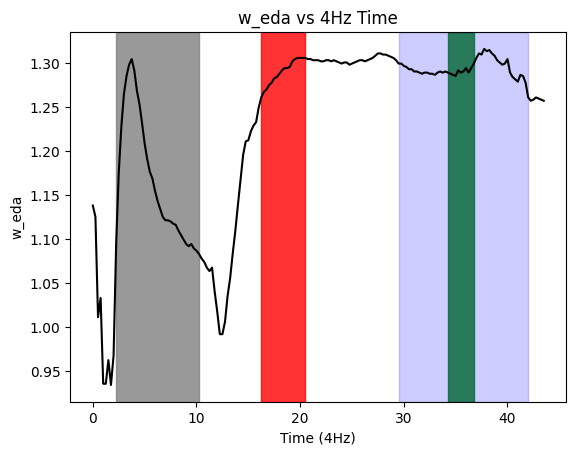

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
data_path = MAIN_PATH + '/data/unprocessed/WESAD/S2/S2.csv'
df = pd.read_csv(data_path)

# Extract the columns
w_eda = df['w_eda']
labels = df['downsampled_labels']


# Calculate the time values
time = df['Time']

# Create a color map for different label values
label_colors = {0: 'white', 1: 'grey', 2: 'red', 3: 'green', 4: 'blue', 5:'yellow', 6: 'yellow'}

# Plot the data
for label_value, color in label_colors.items():
    indices = labels.index[labels == label_value].tolist()
    if indices:
        start = time[indices[0]]
        end = time[indices[-1]]
        alpha = 0.2 if label_value == 4 else 0.8  # Adjust alpha based on label value
        plt.axvspan(start, end, color=color, alpha=alpha)

plt.plot(time, w_eda, color='black')  # Plot the data on top

plt.xlabel('Time (4Hz)')
plt.ylabel('w_eda')
plt.title('w_eda vs 4Hz Time')
plt.show()


In [33]:
# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Loop through the folders and merge the S-subject.csv files
for folder in folders:
    file_path = os.path.join(MAIN_PATH + DATA_SUBPATH,'unprocessed', 'WESAD', folder, f'{folder}.csv')
    if not os.path.exists(file_path):
        print("Document does not exist:", file_path)
        continue
    df = pd.read_csv(file_path)
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Save the merged DataFrame as a CSV file
merged_file_path = os.path.join(MAIN_PATH + DATA_SUBPATH, 'merged_data.csv')
merged_df.to_csv(merged_file_path, index=False)

print("Merged data saved as:", merged_file_path)


Document does not exist: d:\Master of Applied IT/data\unprocessed\WESAD\S12\S12.csv
Merged data saved as: d:\Master of Applied IT/data\merged_data.csv
